# energy and velocity plots for a system with n no of particles

In [30]:
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
rcut = 3.0  ##### Cut-off distance.
rcutsquare = rcut**2
g2 = 1./rcutsquare
g6 = g2*g2*g2
potcut = 4.*g6*(g6-1) ##### Term to be subtracted from pair potential energy

number = 5
Natoms = number**2  # No. of atoms
Ratom = 0.5  ### Radius of atom used to illustrate the atom as a sphere.
rho = 0.5 ### Number Density
L = math.pow(Natoms/rho,0.5) # Length of a side of the square containing the gas.
T0 = 120. # Natural temperature scale, T0 = epsilon/k.
T = 100.   # Temperature in Kelvin



In [32]:
##### Function to compute acceleration for a pair of atoms. 
## r12 is relative displacement of atoms.

def acceleration(r12): 
    r12square = np.dot(r12,r12)
    f2 = 1./r12square
    f6 = f2*f2*f2
    acc = 48.*f2*f6*(f6-0.5)*r12
    return acc

#### Function to compute potential energy for the system of particles. `pos' is the array of position vectors.
def potentialenergy(pos):
    potential = 0.
    for i in range(Natoms-1):
        for j in range(i+1,Natoms):
            rij = pos[i] - pos[j] ## Relative position vector of the pair
            for l in range(2):  ### Calculating the correct separation between particles because of periodic boundary conditions.
                if abs(rij[l])>0.5*L: rij[l] -= L*np.sign(rij[l])
            rijsquare = np.dot(rij,rij)
            if rijsquare < rcutsquare: # Imposing interaction cut-off
                f2 = 1./rijsquare
                f6 = f2*f2*f2
                potential += 4.*f6*(f6-1.) - potcut
    return potential

# Function to generate an image of the disk configuration in the box.
def create_picture(positions):
    plt.cla() # clear current axis
    plt.gca().set_aspect('equal') # get current axis
    plt.axis([0, L, 0, L])
    plt.setp(plt.gca(), xticks=[0, L], yticks=[0, L])
    plt.minorticks_on()
    plt.grid(which='major')
    plt.grid(which='minor', linestyle = ':')
    for x,y in positions:
        atom = plt.Circle((x, y), Ratom, fc='r')
        plt.gca().add_patch(atom)

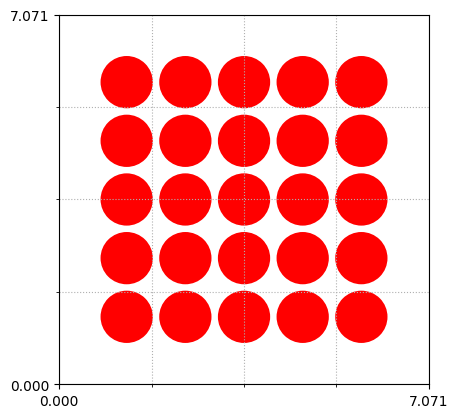

In [33]:
# Atoms are arranged initially in a square lattice 
# configuration with spacing between neighbors equal 
# to equilibrium separation.

equilib_sep = math.pow(2.,1./6.)  ## Equilibrium separation of atoms
wall_spacing = (L-(number-1)*equilib_sep)/2.## Distance between the walls and the initial array of atoms.
poslist = []  # List for positions of atoms
vlist = []   # List for velocities

################  Initialize positions and velocities ##############################################
x, y = wall_spacing, wall_spacing

for i in range(number):
    for j in range(number):
        xi, yi = x + equilib_sep*j, y + equilib_sep*i
        poslist.append((xi,yi))

####### Initially, all particles have the same speed but random velocity directions. ################
v0 = math.sqrt(2.*T/T0)

for i in range(Natoms):
    phi = 2*np.pi*np.random.random()
    vx = v0*np.cos(phi)
    vy = v0*np.sin(phi)
    vlist.append((vx,vy))
###################################################################################################

pos = np.array(poslist)  ### Converts lists to numpy arrays
v = np.array(vlist) ## Scaled velocity
V_cm = np.sum(v, axis = 0)/Natoms ## Correcting for CM velocity.
V = np.array([V_cm,]*Natoms)
v -= V  

create_picture(pos)

In [34]:
##############################initialization of all lists##############################

time = 0. # Initial time.
t_final = 50. # Time upto which simulation is carried out.
dt = 1E-2  # Time step for Verlet Algorithm
potential_energy = potentialenergy(pos)
kinetic_energy = 0.5*sum(np.square(v).sum(axis=1))
energy = kinetic_energy + potential_energy
Time_List = [time]
Energy_List = [energy]
PotentialEnergy_List = [potential_energy]
KineticEnergy_List = [kinetic_energy]
iterations = int(t_final/dt) # Number of iterations of the Verlet Algorithm.
print("no. of iterations: ",iterations)
pos_list=[]
vel_list=[]
meanKE_list=[]

no. of iterations:  5000


In [35]:
##################################### The Verlet Algorithm Loop ###################################
for step in tqdm(range(iterations)):
    pos += v*dt/2. ## Updating positions.
    for i in range(Natoms): ## Imposing periodic boundary conditions.
        for j in range(2):
            if pos[i][j] > L: pos[i][j] -= L          # Torus
            elif pos[i][j] < 0: pos[i][j] += L
    accel = np.zeros((Natoms,2)) ## Initialising acceleration array.
    for i in range(Natoms-1):
        for j in range(i+1,Natoms):
            rij = pos[i] - pos[j]
            for l in range(2):  ### Calculating the correct separation between particles.
                if abs(rij[l])>0.5*L: rij[l] -= L*np.sign(rij[l])
            if np.dot(rij,rij) < rcutsquare:
                acc = acceleration(rij) # Computing acceleration for a pair of particles.
                accel[i] += acc
                accel[j] -= acc
    v += accel*dt  ## Updating velocities.
    pos += v*dt/2. ## Final updating of positions.
    for i in range(Natoms): ## Imposing periodic boundary conditions.
        for j in range(2):
            if pos[i][j] > L: pos[i][j] -= L
            elif pos[i][j] < 0: pos[i][j] += L
        #vel_list.append(np.sqrt((v[i][0])**2+(v[i][1])**2))
    pos_list.append(pos[:,0])
    
    
    potential_energy = potentialenergy(pos)
    kinetic_energy = 0.5*sum(np.square(v).sum(axis=1))
    vel_list.append(np.sqrt(np.square(v).sum(axis=1)))
  
    energy = kinetic_energy + potential_energy
    Energy_List.append(energy)
    PotentialEnergy_List.append(potential_energy)
    KineticEnergy_List.append(kinetic_energy)
    mean_ke= kinetic_energy/Natoms
    meanKE_list.append(mean_ke)

    time += dt
    Time_List.append(time)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:44<00:00, 111.72it/s]


In [36]:
print("mean KE: ",np.mean(meanKE_list))

mean KE:  0.4710903221541055


(array([ 5000.,     0., 10000.,     0.,     0.,     0.,     0.,     0.,
            0.,  5000.,     0.,  5000.,     0.,     0.,     0.,     0.,
            0.,  5000.,  5000.,  5000.,  5000.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,  5000.,     0.,     0.,
            0.,  5000.,  5000.,  5000.,  5000.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,  5000.,
        10000.,  5000.,     0.,  5000.,     0.,     0.,  5000.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,  5000.,     0.,
            0.,     0.,     0.,     0.,  5000.,     0.,     0.,     0.,
            0.,     0.,  5000.,     0.,     0.,     0.,     0.,     0.,
         5000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  5000.]),
 array([0.36472585, 0.43345747, 0.50218908, 0.5709207 , 0.63965232,
        0.70838394, 0.77711556, 0.84584718, 0.9145788 , 0.98331042,
        1.05204204, 1.12077366, 1.18950528, 1.

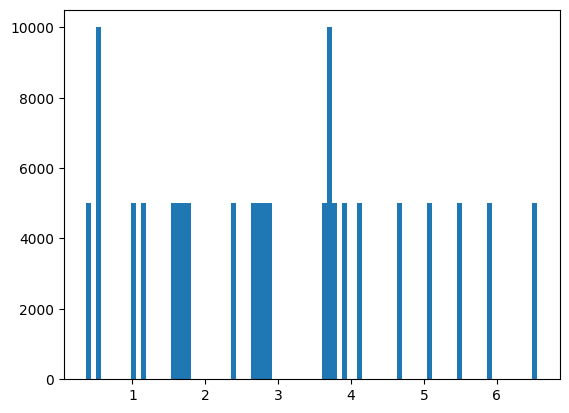

In [7]:
p_list=np.array(pos_list).reshape((((iterations)*Natoms),))
plt.hist(p_list,bins=90)

Text(0, 0.5, 'velocity')

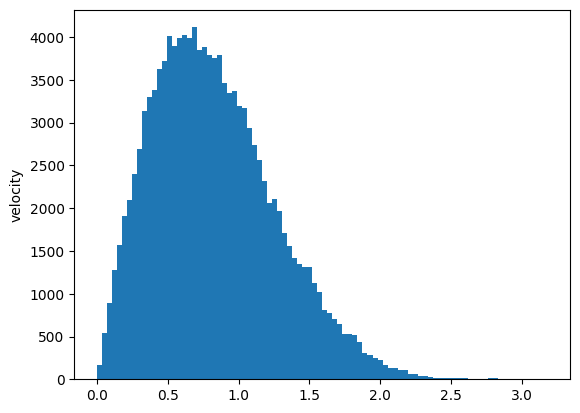

In [8]:
v_list=np.array(vel_list).reshape((((iterations)*Natoms),))
plt.hist(v_list,bins=90)
plt.ylabel('velocity')

Text(0, 0.5, 'Kinetic energy')

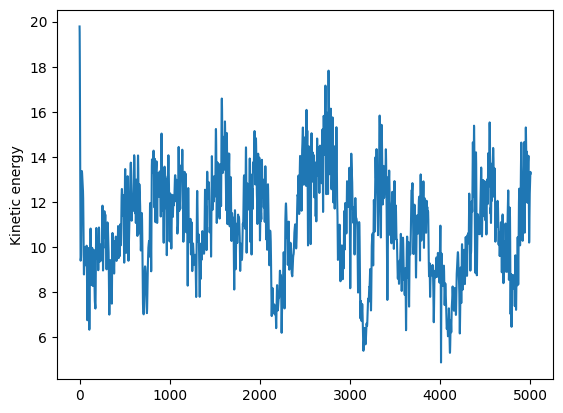

In [9]:
plt.plot(KineticEnergy_List)
plt.ylabel("Kinetic energy")

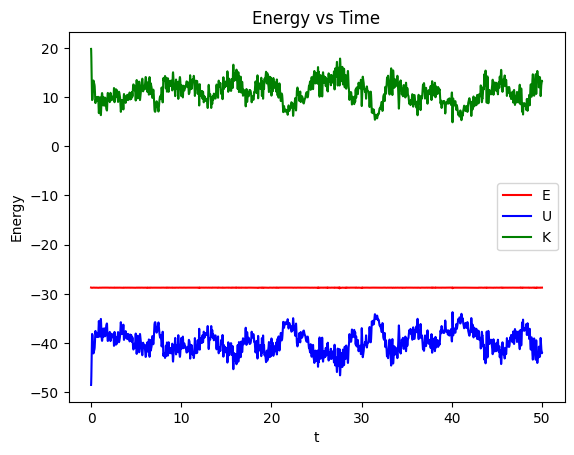

In [10]:
plt.xlabel('t') # Label for the x-axis
plt.ylabel('Energy') # Label for the y-axis
plt.title('Energy vs Time') # Title of plot
plt.plot(Time_List,Energy_List, color = 'r', label="E") 
plt.plot(Time_List,PotentialEnergy_List, color = 'b', label="U")
plt.plot(Time_List,KineticEnergy_List, color = 'g', label="K")
plt.legend();

# System in contact with heat bath

In [ ]:
#plot instantaneous KE wrt time
# show: kinetic energy(mean)=dimensionless temp= 1/root(N) (will come out for large N and large no of iterations)

#simulate the system with contact with a heat bath
#avg KE will not be equal to target temp
#upadate velocity(v) by some lambda*v (update these after few time steps)
#KE' =(lambda)**2  *KE = T
#lambda=root(T/KE)

#Note: plot kE(mean)/N; you will see fluctuations, then force it to the eqilibruim, then again if you see fluctuation, 
#force it to equilibuim; after some time you will see it will vary small around eqlilibruim only
#after some time stop and let the system evolve; so we are forcing equilibrium 
#its like first forcing the system to equilibrim and then letting it evolve
#see how system behaves with low and high temp
#we will see maxwell speed distribution no matter what the temp is
# 


In [11]:
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
rcut = 3.0  ##### Cut-off distance.
rcutsquare = rcut**2
g2 = 1./rcutsquare
g6 = g2*g2*g2
potcut = 4.*g6*(g6-1) ##### Term to be subtracted from pair potential energy

number = 5
Natoms = number**2  # No. of atoms
Ratom = 0.5  ### Radius of atom used to illustrate the atom as a sphere.
rho = 0.5 ### Number Density
L = math.pow(Natoms/rho,0.5) # Length of a side of the square containing the gas.
T0 = 120. # Natural temperature scale, T0 = epsilon/k.
T = 100.   # Temperature in Kelvin

equi_T=T/T0
print("equilibruim or target temperature: ",equi_T) 
print(L)

equilibruim or target temperature:  0.8333333333333334
7.0710678118654755


In [13]:
##### Function to compute acceleration for a pair of atoms. 
## r12 is relative displacement of atoms.

def acceleration(r12): 
    r12square = np.dot(r12,r12)
    f2 = 1./r12square
    f6 = f2*f2*f2
    acc = 48.*f2*f6*(f6-0.5)*r12
    return acc

#### Function to compute potential energy for the system of particles. `pos' is the array of position vectors.
def potentialenergy(pos):
    potential = 0.
    for i in range(Natoms-1):
        for j in range(i+1,Natoms):
            rij = pos[i] - pos[j] ## Relative position vector of the pair
            for l in range(2):  ### Calculating the correct separation between particles because of periodic boundary conditions.
                if abs(rij[l])>0.5*L: rij[l] -= L*np.sign(rij[l])
            rijsquare = np.dot(rij,rij)
            if rijsquare < rcutsquare: # Imposing interaction cut-off
                f2 = 1./rijsquare
                f6 = f2*f2*f2
                potential += 4.*f6*(f6-1.) - potcut
    return potential

# Function to generate an image of the disk configuration in the box.
def create_picture(positions):
    plt.cla() # clear current axis
    plt.gca().set_aspect('equal') # get current axis
    plt.axis([0, L, 0, L])
    plt.setp(plt.gca(), xticks=[0, L], yticks=[0, L])
    plt.minorticks_on()
    plt.grid(which='major')
    plt.grid(which='minor', linestyle = ':')
    for x,y in positions:
        atom = plt.Circle((x, y), Ratom, fc='r')
        plt.gca().add_patch(atom)

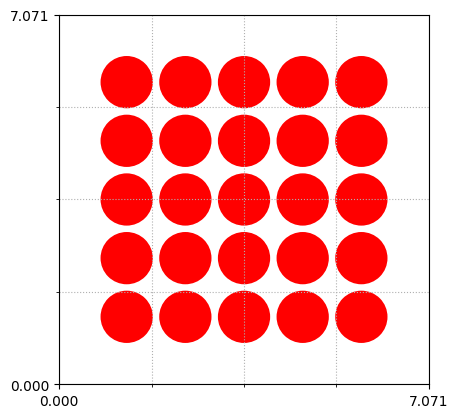

In [14]:
# Atoms are arranged initially in a square lattice 
# configuration with spacing between neighbors equal 
# to equilibrium separation.

equilib_sep = math.pow(2.,1./6.)  ## Equilibrium separation of atoms
wall_spacing = (L-(number-1)*equilib_sep)/2.## Distance between the walls and the initial array of atoms.
poslist = []  # List for positions of atoms
vlist = []   # List for velocities

################  Initialize positions and velocities ##############################################
x, y = wall_spacing, wall_spacing

for i in range(number):
    for j in range(number):
        xi, yi = x + equilib_sep*j, y + equilib_sep*i
        poslist.append((xi,yi))

####### Initially, all particles have the same speed but random velocity directions. ################
v0 = math.sqrt(2.*T/T0)

for i in range(Natoms):
    phi = 2*np.pi*np.random.random()
    vx = v0*np.cos(phi)
    vy = v0*np.sin(phi)
    vlist.append((vx,vy))
###################################################################################################

pos = np.array(poslist)  ### Converts lists to numpy arrays
v = np.array(vlist) ## Scaled velocity
V_cm = np.sum(v, axis = 0)/Natoms ## Correcting for CM velocity.
V = np.array([V_cm,]*Natoms)
v -= V  

create_picture(pos)

In [15]:
##############################initialization of all lists##############################

time = 0. # Initial time.
t_final = 100. # Time upto which simulation is carried out.
dt = 1E-2  # Time step for Verlet Algorithm
potential_energy = potentialenergy(pos)
kinetic_energy = 0.5*sum(np.square(v).sum(axis=1))
energy = kinetic_energy + potential_energy
Time_List = []
Energy_List = []
PotentialEnergy_List = []
KineticEnergy_List = []
iterations = int(t_final/dt) # Number of iterations of the Verlet Algorithm.
print("no. of iterations: ",iterations)
pos_list=[]
vel_list=[]
meanKE_list=[]
mean_ke=equi_T
#lamb_da=np.sqrt(equi_T/kinetic_energy)
#v= lamb_da*v
#print(pos)

no. of iterations:  10000


# Forcing equilibuim

In [16]:
                  ##############forcing equilibrium#########
                    ######## Verlet algorithm #####
                    
for step in tqdm(range(iterations)):
    if step%100==0:          #forcing equilibrium
      lamb_da=np.sqrt(equi_T/mean_ke)
      v= lamb_da*v
    pos += v*dt/2. ## Updating positions.
    for i in range(Natoms): ## Imposing periodic boundary conditions.
        for j in range(2):
            if pos[i][j] > L: pos[i][j] -= L          # Torus
            elif pos[i][j] < 0: pos[i][j] += L
    accel = np.zeros((Natoms,2)) ## Initialising acceleration array.
    for i in range(Natoms-1):
        for j in range(i+1,Natoms):
            rij = pos[i] - pos[j]
            for l in range(2):  ### Calculating the correct separation between particles.
                if abs(rij[l])>0.5*L: rij[l] -= L*np.sign(rij[l])
            if np.dot(rij,rij) < rcutsquare:
                acc = acceleration(rij) # Computing acceleration for a pair of particles.
                accel[i] += acc
                accel[j] -= acc
    v += accel*dt  ## Updating velocities.
    pos += v*dt/2. ## Final updating of positions.
    for i in range(Natoms): ## Imposing periodic boundary conditions.
        for j in range(2):
            if pos[i][j] > L: pos[i][j] -= L
            elif pos[i][j] < 0: pos[i][j] += L
        #vel_list.append(np.sqrt((v[i][0])**2+(v[i][1])**2))
    #pos_list.append(pos[:,0])
    
    
    #potential_energy = potentialenergy(pos)
    kinetic_energy = 0.5*sum(np.square(v).sum(axis=1))
    #lamb_da=np.sqrt(equi_T/kinetic_energy)        #forcing equilibrium
    #v= lamb_da*v
    mean_ke= kinetic_energy/Natoms
    #meanKE_list.append(mean_ke)
    #vel_list.append(np.sqrt(np.square(v).sum(axis=1)))
  
    #energy = kinetic_energy + potential_energy
    #Energy_List.append(energy)
    #PotentialEnergy_List.append(potential_energy)
    #KineticEnergy_List.append(kinetic_energy)

    #time += dt
    #Time_List.append(time)
#print(pos)    

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:58<00:00, 170.92it/s]


#  Now letting system evolve after forcing equilibrium

In [17]:
##################################### The Verlet Algorithm Loop ###################################

######### letting system evolve after forcing it to equilibrium ###########

for step in tqdm(range(iterations)):
    pos += v*dt/2. ## Updating positions.
    for i in range(Natoms): ## Imposing periodic boundary conditions.
        for j in range(2):
            if pos[i][j] > L: pos[i][j] -= L          # Torus
            elif pos[i][j] < 0: pos[i][j] += L
    accel = np.zeros((Natoms,2)) ## Initialising acceleration array.
    for i in range(Natoms-1):
        for j in range(i+1,Natoms):
            rij = pos[i] - pos[j]
            for l in range(2):  ### Calculating the correct separation between particles.
                if abs(rij[l])>0.5*L: rij[l] -= L*np.sign(rij[l])
            if np.dot(rij,rij) < rcutsquare:
                acc = acceleration(rij) # Computing acceleration for a pair of particles.
                accel[i] += acc
                accel[j] -= acc
    v += accel*dt  ## Updating velocities.
    pos += v*dt/2. ## Final updating of positions.
    for i in range(Natoms): ## Imposing periodic boundary conditions.
        for j in range(2):
            if pos[i][j] > L: pos[i][j] -= L
            elif pos[i][j] < 0: pos[i][j] += L
        #vel_list.append(np.sqrt((v[i][0])**2+(v[i][1])**2))
    pos_list.append(pos[:,0])
    
    
    potential_energy = potentialenergy(pos)
    kinetic_energy = 0.5*sum(np.square(v).sum(axis=1))
    #lamb_da=np.sqrt(equi_T/kinetic_energy)        #forcing equilibrium
    #v= lamb_da*v
    mean_ke= kinetic_energy/Natoms
    meanKE_list.append(mean_ke)
    vel_list.append(np.sqrt(np.square(v).sum(axis=1)))
  
    energy = kinetic_energy + potential_energy
    Energy_List.append(energy)
    PotentialEnergy_List.append(potential_energy)
    KineticEnergy_List.append(kinetic_energy)

    time += dt
    Time_List.append(time)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:37<00:00, 102.82it/s]


mean KE:  0.8027093935206634
equilibrium temp:  0.8333333333333334


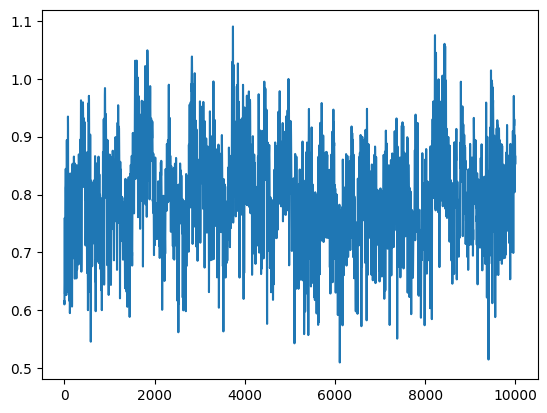

In [18]:
plt.plot(meanKE_list)
print("mean KE: ",np.mean(meanKE_list))      
print("equilibrium temp: ",equi_T)

(array([10000.,     0.,     0.,     0.,     0.,     0., 10000.,     0.,
            0.,     0.,     0.,     0., 10000.,     0.,     0.,     0.,
        10000.,     0., 10000.,     0.,     0., 10000.,     0.,     0.,
            0.,     0.,     0.,     0., 10000.,     0.,     0.,     0.,
        10000.,     0.,     0.,     0., 20000.,     0.,     0.,     0.,
            0.,     0., 10000.,     0.,     0.,     0.,     0., 10000.,
            0.,     0., 10000.,     0.,     0., 20000.,     0.,     0.,
            0., 10000.,     0., 10000.,     0.,     0., 10000.,     0.,
            0.,     0., 10000., 10000.,     0.,     0.,     0.,     0.,
            0., 10000.,     0., 10000.,     0.,     0.,     0.,     0.,
        10000.,     0.,     0., 10000.,     0.,     0.,     0.,     0.,
            0., 10000.]),
 array([0.06553131, 0.13948166, 0.21343201, 0.28738237, 0.36133272,
        0.43528307, 0.50923342, 0.58318377, 0.65713413, 0.73108448,
        0.80503483, 0.87898518, 0.95293554, 1.

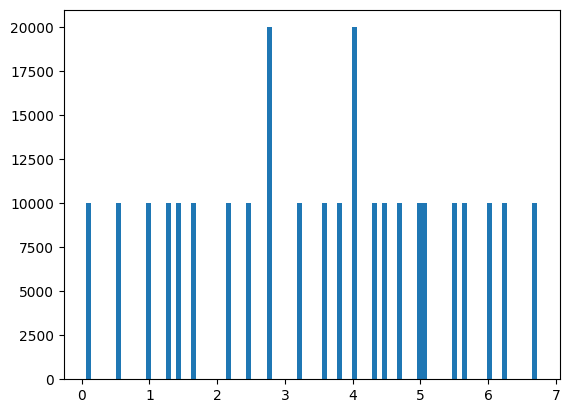

In [19]:
p_list=np.array(pos_list).reshape((((iterations)*Natoms),))
plt.hist(p_list,bins=90)

Text(0, 0.5, 'velocity')

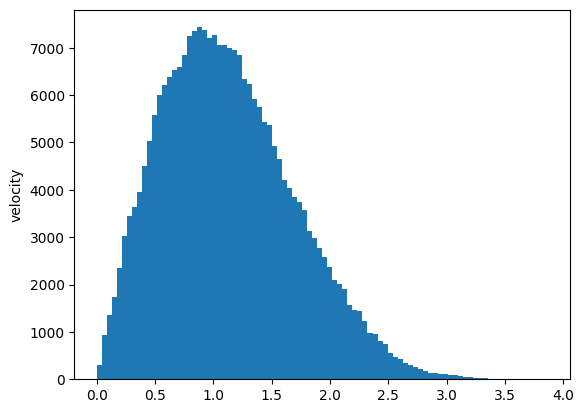

In [20]:
v_list=np.array(vel_list).reshape((((iterations)*Natoms),))
plt.hist(v_list,bins=90)
plt.ylabel('velocity')

Text(0, 0.5, 'Kinetic energy')

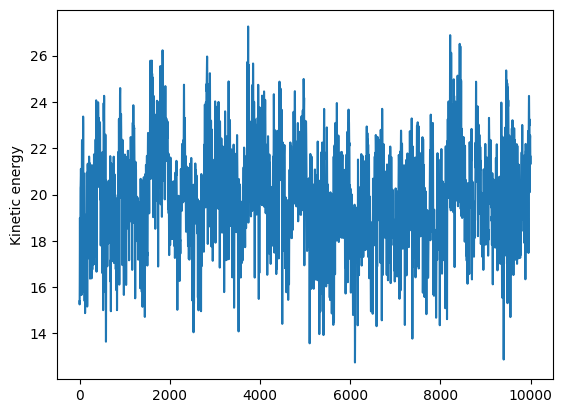

In [21]:
plt.plot(KineticEnergy_List)
plt.ylabel("Kinetic energy")

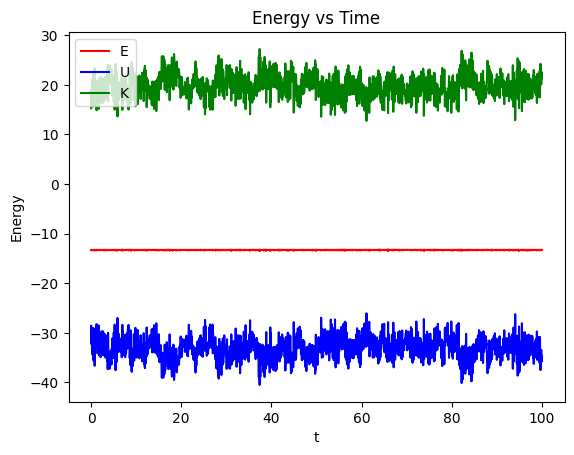

In [22]:
plt.xlabel('t') # Label for the x-axis
plt.ylabel('Energy') # Label for the y-axis
plt.title('Energy vs Time') # Title of plot
plt.plot(Time_List,Energy_List, color = 'r', label="E") 
plt.plot(Time_List,PotentialEnergy_List, color = 'b', label="U")
plt.plot(Time_List,KineticEnergy_List, color = 'g', label="K")
plt.legend();

In [23]:
pos_rdf=pos
v_rdf=v

# Radial Distribution Function

In [ ]:
pos_rdf=pos
v_rdf=v

In [ ]:
delta=0.5                   #bin size
length= int((0.5*L)/delta)
rho_rdf= Natoms/(L*L)
bin=[0]
for i in range(0,length):
  #j=i
  bin.append(bin[i] +delta)

print(bin)  
print(length)
print(len(bin))
n_atoms=[0]*length
print(n_atoms)
r=[]
r_i=0
for i in range(0,length):
  r_i +=delta
  r.append(r_i)

print(r)

[0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
7
8
[0, 0, 0, 0, 0, 0, 0]
[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]


In [ ]:
################### R D F ##################

for step in tqdm(range(100)):
    pos_rdf += v_rdf*dt/2. ## Updating positions.
    for i in range(Natoms): ## Imposing periodic boundary conditions.
        for j in range(2):
            if pos_rdf[i][j] > L: pos_rdf[i][j] -= L          # Torus
            elif pos_rdf[i][j] < 0: pos_rdf[i][j] += L
    accel = np.zeros((Natoms,2)) ## Initialising acceleration array.
    for i in range(Natoms-1):
        for j in range(i+1,Natoms):
            rij = pos_rdf[i] - pos_rdf[j]
            for l in range(2):  ### Calculating the correct separation between particles.
                if abs(rij[l])>0.5*L: rij[l] -= L*np.sign(rij[l])
            if step%10==0:      #RDF
              rij_rdf=rij
              dist=np.sqrt((rij_rdf[0])**2+ (rij_rdf[1])**2)
              if dist<= L/2:
                for i in range(length):
                  if dist>bin[i] and dist<=bin[i+1]:
                    n_atoms[i] += 1

            if np.dot(rij,rij) < rcutsquare:
                acc = acceleration(rij) # Computing acceleration for a pair of particles.
                accel[i] += acc
                accel[j] -= acc
    v_rdf += accel*dt  ## Updating velocities.
    pos_rdf += v_rdf *dt/2. ## Final updating of positions.
    for i in range(Natoms): ## Imposing periodic boundary conditions.
        for j in range(2):
            if pos_rdf[i][j] > L: pos_rdf[i][j] -= L
            elif pos_rdf[i][j] < 0: pos_rdf[i][j] += L
    time += dt

  

100%|██████████| 100/100 [00:00<00:00, 224.58it/s]


In [ ]:
print(n_atoms)
print(r)

[0, 0, 7, 7, 15, 13, 21]
[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]


In [ ]:
g_r=[]
for i in range(length):
  g_r.append((n_atoms[i]) / (rho*2*3.14*r[i]*delta))
print(g_r)

[0.0, 0.0, 2.9723991507431, 2.229299363057325, 3.8216560509554136, 2.760084925690021, 3.821656050955414]


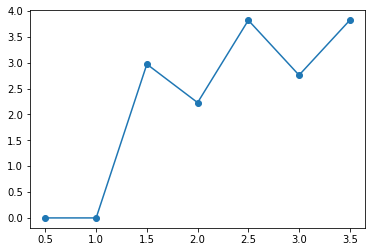

In [ ]:
plt.plot(r,g_r,marker='o')

In [ ]:
no_of_data_samples= sum(n_atoms)
print(no_of_data_samples)

400


In [ ]:
for i in range(len(g_r)):
  g_r[i]= (g_r[i])/no_of_data_samples

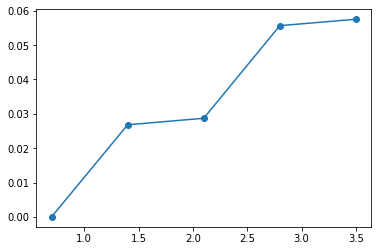

In [ ]:
plt.plot(r,g_r,marker='o')